# Preprocessing of Image Data for Convolutional Neural Net

## This approach was adopted from the following guide: [link](https://deeplizard.com/learn/video/LhEMXbjGV_4)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import time
%matplotlib inline

In [2]:
# Organize data into train, valid, test dirs
print(f'Current Working Directory: {os.getcwd()}')
home_dir = os.getcwd()
os.chdir('./data/')

n_samples_train = 500
n_samples_valid = 100
n_samples_test = 50

if os.path.isdir('train_test_split') is False:
    os.makedirs('train_test_split')

os.chdir('./train_test_split')
    
if os.path.isdir('train/real') is False:
    os.makedirs('train/real')
    os.makedirs('train/synthetic')
    os.makedirs('valid/real')
    os.makedirs('valid/synthetic')
    os.makedirs('test/real')
    os.makedirs('test/synthetic')
    
    os.chdir(f'{home_dir}/data/real/thumbnails128x128/')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/real')
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/real')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/real') 
        
    os.chdir(f'{home_dir}/data/generated/Low Res')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/synthetic')        
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/synthetic')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/synthetic')

os.chdir(home_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [3]:
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [4]:
train_path = './data/train_test_split/train/'
valid_path = './data/train_test_split/valid'
test_path = './data/train_test_split/test'

In [5]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
#         ax.imshow(img) # original code; was getting warnings about clipping
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

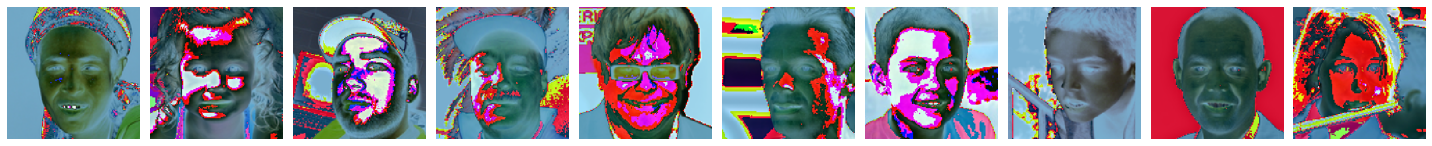

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels);

# Neural Net

In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [14]:
n_samples_train//n_batch

50

In [15]:
time_0 = time.time()

model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 8s - loss: 20.8236 - accuracy: 0.5920 - val_loss: 3.8879 - val_accuracy: 0.7500 - 8s/epoch - 151ms/step
Epoch 2/10
50/50 - 7s - loss: 4.2310 - accuracy: 0.7360 - val_loss: 2.3096 - val_accuracy: 0.7600 - 7s/epoch - 149ms/step
Epoch 3/10
50/50 - 7s - loss: 1.7863 - accuracy: 0.8220 - val_loss: 2.7673 - val_accuracy: 0.7800 - 7s/epoch - 149ms/step
Epoch 4/10
50/50 - 7s - loss: 1.6183 - accuracy: 0.8460 - val_loss: 0.9782 - val_accuracy: 0.8300 - 7s/epoch - 149ms/step
Epoch 5/10
50/50 - 7s - loss: 1.1458 - accuracy: 0.8520 - val_loss: 2.1451 - val_accuracy: 0.7400 - 7s/epoch - 149ms/step
Epoch 6/10
50/50 - 7s - loss: 0.4069 - accuracy: 0.9380 - val_loss: 1.7003 - val_accuracy: 0.8100 - 7s/epoch - 149ms/step
Epoch 7/10
50/50 - 7s - loss: 0.3753 - accuracy: 0.9160 - val_loss: 1.0506 - val_accuracy: 0.8300 - 7s/epoch - 149ms/step
Epoch 8/10
50/50 - 7s - loss: 0.4326 - accuracy: 0.9200 - val_loss: 1.4660 - val_accuracy: 0.7700 - 7s/epoch - 149ms/step
Epoch 9/10
50/50 - 7s -

In [18]:
model.history.history

{'loss': [20.823638916015625,
  4.23102331161499,
  1.7863062620162964,
  1.6182664632797241,
  1.1458123922348022,
  0.4069058895111084,
  0.37529632449150085,
  0.43256789445877075,
  0.1652965247631073,
  0.11144918948411942],
 'accuracy': [0.5920000076293945,
  0.7360000014305115,
  0.8220000267028809,
  0.8460000157356262,
  0.8519999980926514,
  0.9380000233650208,
  0.9160000085830688,
  0.9200000166893005,
  0.9520000219345093,
  0.9760000109672546],
 'val_loss': [3.887948513031006,
  2.3095548152923584,
  2.767261266708374,
  0.9782120585441589,
  2.145068407058716,
  1.7003493309020996,
  1.0506459474563599,
  1.4659967422485352,
  1.2987627983093262,
  1.0055116415023804],
 'val_accuracy': [0.75,
  0.7599999904632568,
  0.7799999713897705,
  0.8299999833106995,
  0.7400000095367432,
  0.8100000023841858,
  0.8299999833106995,
  0.7699999809265137,
  0.7900000214576721,
  0.8299999833106995]}

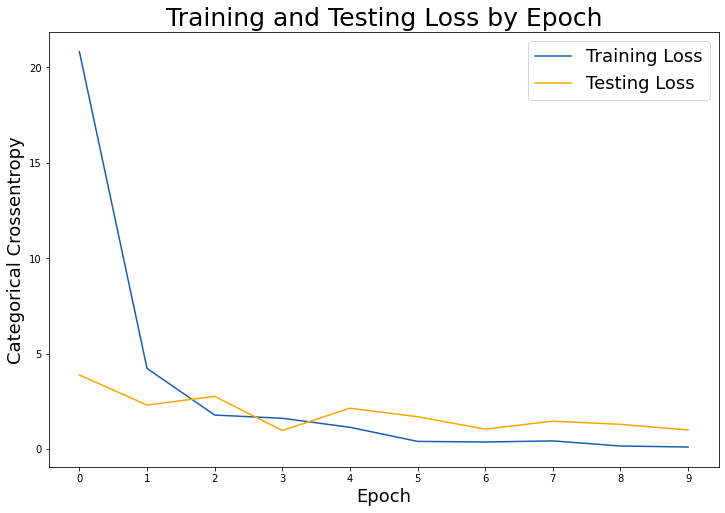

In [19]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

# Check out our train loss and test loss over epochs.
train_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']
epoch_labels = model.history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

## Testing the difference in performance when real and synthetic images have been passed through the same interpolation for downscaling

In [95]:
os.chdir(home_dir)
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [91]:
# Function for moving data into train, valid, test dirs

def img_train_test(split_dir, real_dir, synth_dir, n_samples_train=500, n_samples_valid=100, n_samples_test=50):
    
    print(f'Current Working Directory: {os.getcwd()}')
    home_dir = os.getcwd()

    n_samples_train = n_samples_train
    n_samples_valid = n_samples_valid
    n_samples_test = n_samples_test

    if os.path.isdir(home_dir + split_dir) is False:
        os.makedirs(home_dir + split_dir)
    
    full_dir = (home_dir + split_dir)
    
    os.chdir(full_dir)
    if os.path.isdir('train/real') is False:
        os.makedirs('train/real')
        os.makedirs('train/synthetic')
        os.makedirs('valid/real')
        os.makedirs('valid/synthetic')
        os.makedirs('test/real')
        os.makedirs('test/synthetic')

#         os.chdir(home_dir + real_dir)
        for i in random.sample(glob.glob('*'), n_samples_train):
            shutil.copy(i, f'{home_dir}{split_dir}/train/real')
        for i in random.sample(glob.glob('*'), n_samples_valid):
            shutil.copy(i, f'{home_dir}{split_dir}/valid/real')
        for i in random.sample(glob.glob('*'), n_samples_test):
            shutil.copy(i, f'{home_dir}{split_dir}/test/real') 

#         os.chdir(home_dir + synth_dir)
        for i in random.sample(glob.glob('*'), n_samples_train):
            shutil.copy(i, f'{home_dir}{split_dir}/train/synthetic')        
        for i in random.sample(glob.glob('*'), n_samples_valid):
            shutil.copy(i, f'{home_dir}{split_dir}/valid/synthetic')
        for i in random.sample(glob.glob('*'), n_samples_test):
            shutil.copy(i, f'{home_dir}{split_dir}/test/synthetic')

    os.chdir(home_dir)

In [96]:
split_dir = '/data/INTER_AREA/train_test_split'
real_dir = '/data/real/FFHQ-high-res/INTER_AREA'
synth_dir = '/data/generated/Low Res'

In [357]:
os.path.normpath(home_dir + split_dir)

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask\\data\\INTER_AREA\\train_test_split'

In [98]:
img_train_test(split_dir, real_dir, synth_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [99]:
train_path = f'{home_dir}{split_dir}/train'
valid_path = f'{home_dir}{split_dir}/valid'
test_path = f'{home_dir}{split_dir}/test'

In [100]:
print(train_path + '\n' + valid_path + '\n' + test_path)

C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/train
C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/valid
C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/test


In [101]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [102]:
model_inter_area = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [103]:
model_inter_area.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [104]:
model_inter_area.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
time_0 = time.time()

model_inter_area.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 9s - loss: 25.0378 - accuracy: 0.6160 - val_loss: 29.3123 - val_accuracy: 0.5900 - 9s/epoch - 170ms/step
Epoch 2/10
50/50 - 7s - loss: 8.6080 - accuracy: 0.7060 - val_loss: 8.5199 - val_accuracy: 0.6500 - 7s/epoch - 149ms/step
Epoch 3/10
50/50 - 7s - loss: 4.4252 - accuracy: 0.7320 - val_loss: 3.5353 - val_accuracy: 0.8000 - 7s/epoch - 149ms/step
Epoch 4/10
50/50 - 7s - loss: 2.2961 - accuracy: 0.8260 - val_loss: 0.9939 - val_accuracy: 0.8700 - 7s/epoch - 149ms/step
Epoch 5/10
50/50 - 7s - loss: 1.1655 - accuracy: 0.8460 - val_loss: 4.6165 - val_accuracy: 0.6600 - 7s/epoch - 148ms/step
Epoch 6/10
50/50 - 7s - loss: 0.9882 - accuracy: 0.8600 - val_loss: 0.7921 - val_accuracy: 0.9000 - 7s/epoch - 148ms/step
Epoch 7/10
50/50 - 7s - loss: 0.3581 - accuracy: 0.9340 - val_loss: 0.9452 - val_accuracy: 0.8800 - 7s/epoch - 149ms/step
Epoch 8/10
50/50 - 7s - loss: 0.1229 - accuracy: 0.9680 - val_loss: 0.7646 - val_accuracy: 0.8900 - 7s/epoch - 149ms/step
Epoch 9/10
50/50 - 7s 

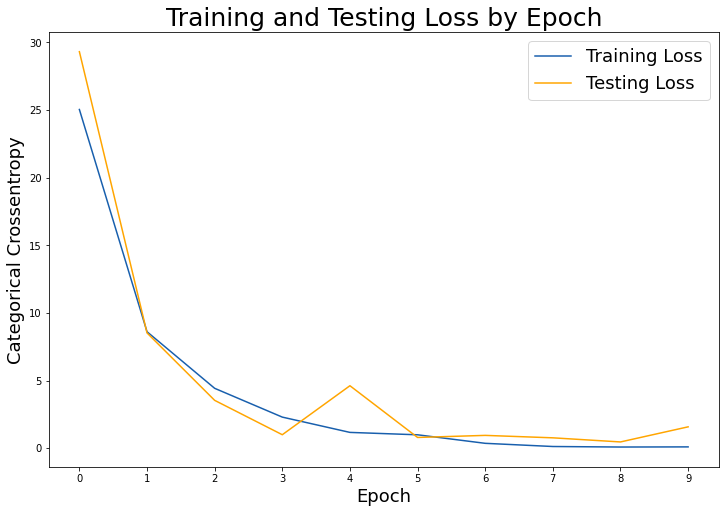

In [106]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

# Check out our train loss and test loss over epochs.
train_loss = model_inter_area.history.history['loss']
test_loss = model_inter_area.history.history['val_loss']
epoch_labels = model_inter_area.history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

### Model Predictions

In [355]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [323]:
test_batches.class_indices

{'real': 0, 'synthetic': 1}

In [356]:
test_batches.index_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

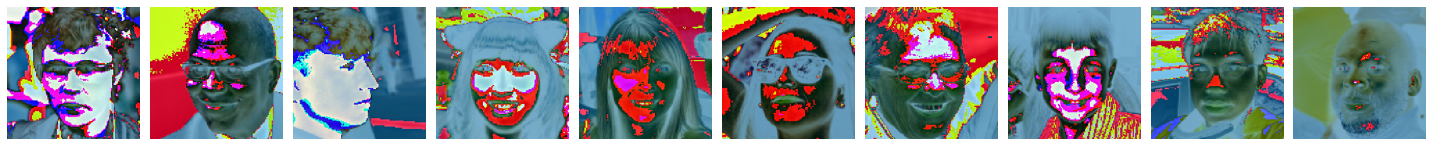

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [353]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [354]:
test_batches.batch_index

1

In [351]:
test_batches.reset()

In [309]:
test_batches[0]

(array([[[[ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          ...,
          [-5.8939003e+01, -4.7778999e+01, -3.4680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01]],
 
         [[ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          ...,
          [-5.8939003e+01, -4.7778999e+01, -3.4680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01]],
 
         [[ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          [ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          [ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          ...,
          [-5.7939003e+01, -4.5778999e+01, -3.168

In [109]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [110]:
preds = model.predict(x=test_batches, verbose=0)

In [114]:
preds[:10]

array([[2.3757673e-06, 9.9999762e-01],
       [8.7909818e-01, 1.2090179e-01],
       [6.0872060e-01, 3.9127946e-01],
       [1.0000000e+00, 6.2558336e-09],
       [9.9305809e-01, 6.9418582e-03],
       [9.9998486e-01, 1.5169209e-05],
       [9.9998868e-01, 1.1296217e-05],
       [9.8939908e-01, 1.0600974e-02],
       [1.0000000e+00, 2.5305206e-22],
       [9.9989653e-01, 1.0343407e-04]], dtype=float32)

In [126]:
bin_preds = np.argmax(preds, axis=-1)
bin_preds[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [127]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=bin_preds)

In [128]:
# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[42  8]
 [10 40]]


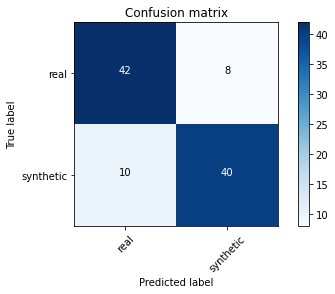

In [129]:
plot_confusion_matrix(cm, {'real': 0, 'synthetic': 1})

In [125]:
type(test_batches)

keras.preprocessing.image.DirectoryIterator

In [267]:
test_batches.index_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [276]:
true_classification = test_batches.classes
true_classification[0]

0

In [281]:
test_batches.batch_index

1

In [288]:
test_batches.classes - bin_preds

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  0,  1,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [291]:
test_batches.samples

100

In [304]:
def collect_missed_predictions(batch_iterator, predictions):
    incorrect_pred_idxs = []
    incorrect_preds = []
    delta = batch_iterator.classes - predictions
    for i in range(batch_iterator.samples):
        if delta[i] != 0:
            if delta[i] == -1:
                metric = 'False Positive'
            else:
                metric = 'False Negative'
            incorrect_pred_idxs.append((i, metric))
    
    return incorrect_pred_idxs

In [305]:
missed_predictions = collect_missed_predictions(test_batches, bin_preds)

In [306]:
missed_predictions

[(0, 'False Positive'),
 (10, 'False Positive'),
 (11, 'False Positive'),
 (19, 'False Positive'),
 (21, 'False Positive'),
 (23, 'False Positive'),
 (39, 'False Positive'),
 (41, 'False Positive'),
 (51, 'False Negative'),
 (60, 'False Negative'),
 (65, 'False Negative'),
 (71, 'False Negative'),
 (73, 'False Negative'),
 (75, 'False Negative'),
 (77, 'False Negative'),
 (78, 'False Negative'),
 (82, 'False Negative'),
 (87, 'False Negative')]

## Use pretrained model (VGG16)

In [358]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 59s 0us/step


In [361]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [365]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [366]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [367]:
for layer in model.layers:
    layer.trainable = False

In [368]:
model.add(Dense(units=2, activation='softmax'))

In [369]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [370]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [371]:
time_0 = time.time()

model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 30s - loss: 0.8546 - accuracy: 0.5440 - val_loss: 0.6623 - val_accuracy: 0.6400 - 30s/epoch - 595ms/step
Epoch 2/10
50/50 - 20s - loss: 0.5997 - accuracy: 0.7080 - val_loss: 0.4882 - val_accuracy: 0.7700 - 20s/epoch - 406ms/step
Epoch 3/10
50/50 - 20s - loss: 0.5983 - accuracy: 0.7240 - val_loss: 0.5018 - val_accuracy: 0.8300 - 20s/epoch - 409ms/step
Epoch 4/10
50/50 - 20s - loss: 0.5170 - accuracy: 0.7600 - val_loss: 0.4693 - val_accuracy: 0.8200 - 20s/epoch - 405ms/step
Epoch 5/10
50/50 - 20s - loss: 0.5027 - accuracy: 0.7700 - val_loss: 0.4983 - val_accuracy: 0.7900 - 20s/epoch - 405ms/step
Epoch 6/10
50/50 - 20s - loss: 0.5218 - accuracy: 0.7440 - val_loss: 0.5046 - val_accuracy: 0.8000 - 20s/epoch - 402ms/step
Epoch 7/10
50/50 - 20s - loss: 0.4500 - accuracy: 0.7780 - val_loss: 0.5188 - val_accuracy: 0.7700 - 20s/epoch - 401ms/step
Epoch 8/10
50/50 - 20s - loss: 0.4186 - accuracy: 0.8260 - val_loss: 0.4871 - val_accuracy: 0.7800 - 20s/epoch - 396ms/step
Epoch 9/

Very interesting. This model is highly complex, and designed to distinguish between many types of objects/creatures. Although some of the features used to appropriately classify these targets are likely to be relevant/useful towards my ends, I suspect those features are drowned out by the enormous ammount of other features that simply don't apply when comparing two very similar, human shaped classes. I am going to proceed with tailoring my own, homegrown, model to the task.

In [380]:
# adding fully connected layers and dropout

model_inter_area_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.1),
    Dense(64, activation='relu'),
    Dropout(.1),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_2.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 6s - loss: 25.4444 - accuracy: 0.5120 - val_loss: 2.1429 - val_accuracy: 0.4800 - 6s/epoch - 112ms/step
Epoch 2/10
50/50 - 5s - loss: 4.8877 - accuracy: 0.5760 - val_loss: 0.8602 - val_accuracy: 0.6500 - 5s/epoch - 93ms/step
Epoch 3/10
50/50 - 5s - loss: 2.0525 - accuracy: 0.6220 - val_loss: 0.6280 - val_accuracy: 0.6800 - 5s/epoch - 93ms/step
Epoch 4/10
50/50 - 5s - loss: 1.4976 - accuracy: 0.6240 - val_loss: 0.5559 - val_accuracy: 0.7500 - 5s/epoch - 93ms/step
Epoch 5/10
50/50 - 5s - loss: 0.8787 - accuracy: 0.7040 - val_loss: 0.5421 - val_accuracy: 0.7800 - 5s/epoch - 92ms/step
Epoch 6/10
50/50 - 5s - loss: 0.7570 - accuracy: 0.6840 - val_loss: 0.4691 - val_accuracy: 0.8500 - 5s/epoch - 93ms/step
Epoch 7/10
50/50 - 5s - loss: 0.5055 - accuracy: 0.7880 - val_loss: 0.5402 - val_accuracy: 0.7600 - 5s/epoch - 93ms/step
Epoch 8/10
50/50 - 5s - loss: 0.3680 - accuracy: 0.8780 - val_loss: 0.4090 - val_accuracy: 0.8600 - 5s/epoch - 93ms/step
Epoch 9/10
50/50 - 5s - loss: 

In [386]:
# Adjusting dropout weight and increasing number of epochs
np.random.seed(42)

model_inter_area_3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.2),
    Dense(64, activation='relu'),
    Dropout(.2),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_3.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

ResourceExhaustedError: OOM when allocating tensor with shape[200704,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
# Adjusting dropout weight

model_inter_area_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.2),
    Dense(64, activation='relu'),
    Dropout(.2),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_4.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')